In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import randomforest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('/Users/zheguan/CWR_fig/credit-card-fraud-detection/Base.csv')
df.head()

fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           0     0.3               0.986506                         -1   
1           0     0.8               0.617426                         -1   
2           0     0.8               0.996707                          9   
3           0     0.6               0.475100                         11   
4           0     0.9               0.842307                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            25            40            0.006735   
1                            89            20            0.010095   
2                            14            40            0.012316   
3                            14            30            0.006991   
4                            29            40            5.742626   

   intended_balcon_amount payment_type  zip_count_4w  ...  has_other_cards  \
0              102.453711           AA          1059  ...                0   
1               -0.849551           AD          1658  ...                0   
2               -1.490386           AB          1095  ...                0   
3               -1.863101           AB          3483  ...                0   
4               47.152498           AA          2339  ...                0   

   proposed_credit_limit  foreign_request    source  \
0                 1500.0                0  INTERNET   
1                 1500.0                0  INTERNET   
2                  200.0                0  INTERNET   
3                  200.0                0  INTERNET   
4                  200.0                0  INTERNET   

   session_length_in_minutes device_os  keep_alive_session  \
0                  16.224843     linux                   1   
1                   3.363854     other                   1   
2                  22.730559   windows                   0   
3                  15.215816     linux                   1   
4                   3.743048     other                   0   

   device_distinct_emails_8w device_fraud_count  month  
0                          1                  0      0  
1                          1                  0      0  
2                          1                  0      0  
3                          1                  0      0  
4                          1                  0      0  

[5 rows x 32 columns]

In [2]:
## check missing values
df.isnull().sum()

fraud_bool                          0
income                              0
name_email_similarity               0
prev_address_months_count           0
current_address_months_count        0
customer_age                        0
days_since_request                  0
intended_balcon_amount              0
payment_type                        0
zip_count_4w                        0
velocity_6h                         0
velocity_24h                        0
velocity_4w                         0
bank_branch_count_8w                0
date_of_birth_distinct_emails_4w    0
employment_status                   0
credit_risk_score                   0
email_is_free                       0
housing_status                      0
phone_home_valid                    0
phone_mobile_valid                  0
bank_months_count                   0
has_other_cards                     0
proposed_credit_limit               0
foreign_request                     0
source                              0
session_leng

Text(0.5, 1.0, 'the number of fraud vs no fraud transactions')

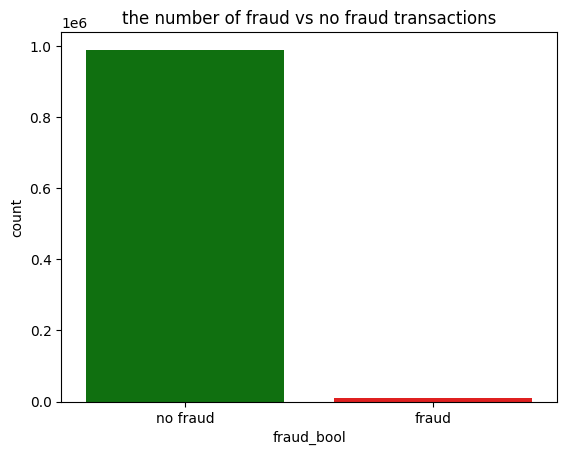

In [3]:
sns.countplot( x = df['fraud_bool'].map({0: 'no fraud', 1: 'fraud'}),palette = ["green","red"])
plt.title("the number of fraud vs no fraud transactions")

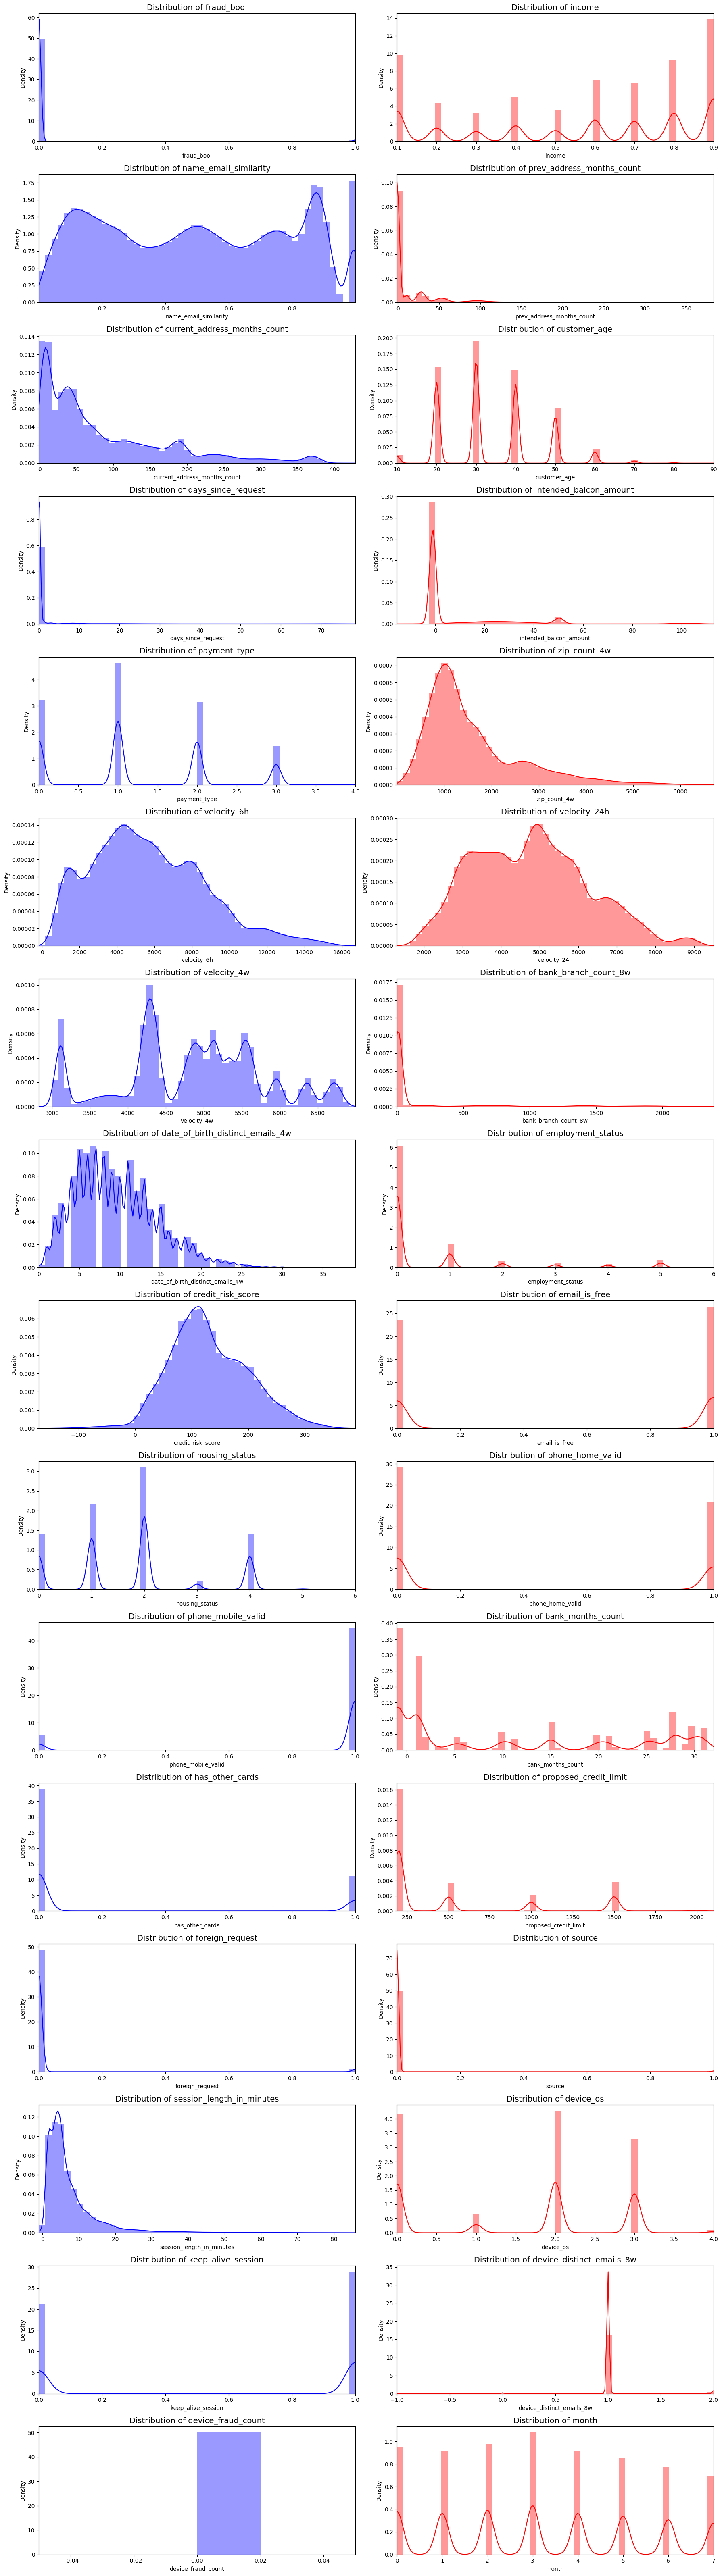

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

#transfer object columns to numerics:
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


num_cols = df.select_dtypes(include=['int64', 'float64']).columns
fig, axes = plt.subplots(len(num_cols)//2, 2, figsize=(18, 4 * (len(num_cols)//2)))
axes = axes.flatten()  

for i, col in enumerate(num_cols):
    sns.distplot(df[col].dropna(), ax=axes[i], color='b' if i % 2 == 0 else 'r')
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlim([df[col].min(), df[col].max()])

plt.tight_layout()
plt.show()

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

print('No Frauds', round(df['fraud_bool'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['fraud_bool'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

X = df.drop('fraud_bool', axis=1)
y = df['fraud_bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify= y, random_state=42) # random number for repete
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

No Frauds 98.9 % of the dataset
Frauds 1.1 % of the dataset


In [20]:
#Scale from 0 to 1 with two methods
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns


for i, col in enumerate(num_cols):
    train_data['scaled_'+col] = rob_scaler.fit_transform(train_data[col].values.reshape(-1,1))
    train_data.drop([col], axis=1, inplace=True)

In [21]:
train_data

scaled_income  scaled_name_email_similarity  \
39111             0.2                     -0.495223   
822700           -0.8                      0.822438   
914415           -1.0                      0.313644   
581307            0.4                      0.532831   
603136            0.6                      0.945077   
...               ...                           ...   
216137           -1.0                      0.262142   
72154            -1.0                      0.085377   
104022           -0.2                      0.580282   
622382           -1.0                      0.839057   
228494           -1.0                      0.214160   

        scaled_prev_address_months_count  scaled_current_address_months_count  \
39111                           0.000000                             0.099099   
822700                         15.384615                            -0.252252   
914415                          7.384615                            -0.450450   
581307                          0.000000                             0.630631   
603136                          8.000000                            -0.387387   
...                                  ...                                  ...   
216137                          0.000000                             0.630631   
72154                           0.000000                            -0.351351   
104022                          0.769231                            -0.387387   
622382                          4.538462                            -0.396396   
228494                          7.230769                            -0.387387   

        scaled_customer_age  scaled_days_since_request  \
39111                   1.0                   0.499420   
822700                  2.0                  -0.052896   
914415                  0.5                   1.601194   
581307                  0.0                  -0.501573   
603136                 -0.5                  -0.226456   
...                     ...                        ...   
216137                  1.0                  -0.244398   
72154                   1.0                  -0.521234   
104022                  1.0                   0.063759   
622382                 -0.5                  -0.068579   
228494                  0.0                   0.184058   

        scaled_intended_balcon_amount  scaled_payment_type  \
39111                        8.232755                 -0.5   
822700                       2.631288                 -0.5   
914415                      -0.092757                  0.0   
581307                       0.046342                  0.0   
603136                       0.052555                  0.0   
...                               ...                  ...   
216137                      -0.004401                  0.5   
72154                       -0.092794                  0.0   
104022                      -0.040897                  0.0   
622382                       0.065463                  0.0   
228494                       1.468037                 -0.5   

        scaled_zip_count_4w  scaled_velocity_6h  ...  \
39111              0.040000            1.754032  ...   
822700            -0.409524            1.036527  ...   
914415            -0.977143           -0.733467  ...   
581307            -0.350476            0.014354  ...   
603136             2.706667            0.497494  ...   
...                     ...                 ...  ...   
216137            -0.321905           -0.489025  ...   
72154             -0.494286            0.354056  ...   
104022             2.088571            1.049697  ...   
622382            -0.420952           -0.038751  ...   
228494            -0.786667           -0.504188  ...   

        scaled_proposed_credit_limit  scaled_foreign_request  scaled_source  \
39111                       4.333333                     0.0            0.0   
822700                      1.000000                     0.0            0.0   
914415                

In [8]:


X = train_data.drop('fraud_bool', axis=1)
y = train_data['fraud_bool']

t0 = time.time()
X_reduced_pca = PCA(n_components=7, random_state=42).fit_transform(X.values)
t1 = time.time()
rint("PCA took {:.2} s".format(t1 - t0))



PCA took 2.8 s


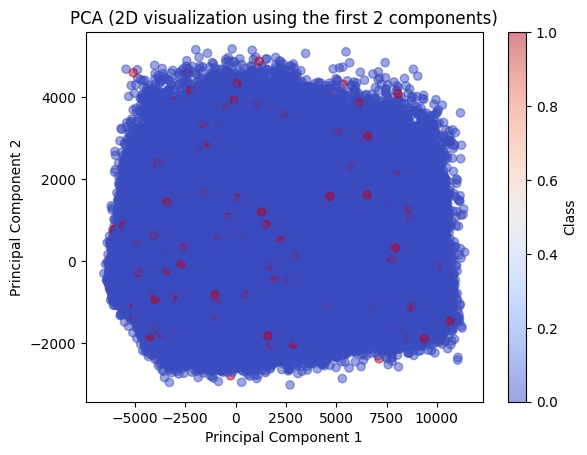

In [9]:
import matplotlib.pyplot as plt

plt.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 2], c=y, cmap='coolwarm', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA (2D visualization using the first 2 components)')
plt.colorbar(label='Class')
plt.show()


In [23]:
# T-SNE Implementation
#from openTSNE import TSNE

#t0 = time.time()
#X_reduced_tsne = TSNE(n_components=2, random_state=42,n_jobs=7,n_iter = 5).fit(X_reduced_pca)
#t1 = time.time()
#print("T-SNE took {:.2} s".format(t1 - t0))

# to study the minitory category carefully, we generate a balanced sample by random sampling.

train_data = train_data.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = train_data.loc[train_data['scaled_fraud_bool'] == 1]
non_fraud_df = train_data.loc[train_data['scaled_fraud_bool'] == 0][:train_data['scaled_fraud_bool'].value_counts()[1]]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()


scaled_income  scaled_name_email_similarity  \
122714            0.2                     -0.690998   
59531            -0.8                      0.424000   
875876            0.4                     -0.672037   
630831            0.4                      0.741351   
882841           -1.0                      0.466197   

        scaled_prev_address_months_count  scaled_current_address_months_count  \
122714                               0.0                             0.117117   
59531                                0.0                            -0.090090   
875876                               0.0                             0.216216   
630831                               0.0                            -0.198198   
882841                               0.0                             1.180180   

        scaled_customer_age  scaled_days_since_request  \
122714                 -0.5                   0.110910   
59531                   0.0                  -0.060478   
875876                  1.0                   1.468290   
630831                  1.0                   0.732121   
882841                  1.0                  -0.752489   

        scaled_intended_balcon_amount  scaled_payment_type  \
122714                       8.241997                 -0.5   
59531                       17.250951                 -0.5   
875876                       4.197956                 -0.5   
630831                      -0.073330                  1.0   
882841                       8.010868                 -0.5   

        scaled_zip_count_4w  scaled_velocity_6h  ...  \
122714             0.468571            0.819812  ...   
59531             -0.008571            0.283444  ...   
875876             0.610476            0.189104  ...   
630831            -0.188571           -1.181843  ...   
882841            -0.062857           -0.460169  ...   

        scaled_proposed_credit_limit  scaled_foreign_request  scaled_source  \
122714                      0.000000                     0.0            0.0   
59531                       4.333333                     0.0            0.0   
875876                      1.000000                     0.0            0.0   
630831                      4.333333                     0.0            0.0   
882841                      1.000000                     1.0            0.0   

        scaled_session_length_in_minutes  scaled_device_os  \
122714                         -0.313421         -0.666667   
59531                          -0.403668         -0.666667   
875876                          0.917488         -0.666667   
630831                          2.208806          0.333333   
882841                          0.233218         -0.333333   

        scaled_keep_alive_session  scaled_device_distinct_emails_8w  \
122714                        0.0                               0.0   
59531                         0.0                               0.0   
875876                       -1.0                               0.0   
630831                       -1.0                               0.0   
882841                        0.0                               0.0   

        scaled_device_fraud_count  scaled_month  scaled_fraud_bool  
122714                        0.0         -0.75                1.0  
59531                         0.0         -0.75                0.0  
875876                        0.0          0.75                1.0  
630831                        0.0          0.25                1.0  
882841                        0.0          0.75                1.0  

[5 rows x 32 columns]

Distribution of the Classes in the subsample dataset
scaled_fraud_bool
1.0    0.5
0.0    0.5
Name: count, dtype: float64


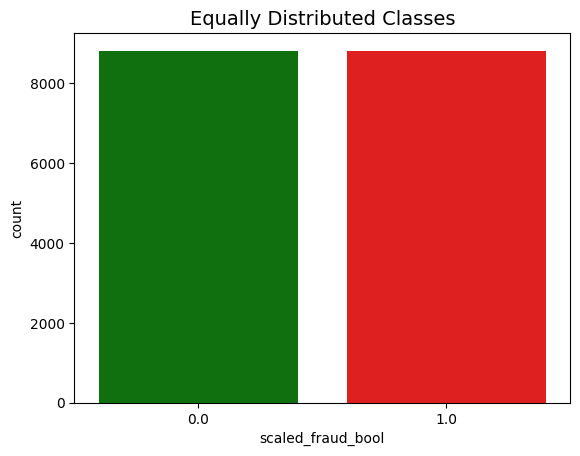

In [24]:
# check if training sample is balanced

print('Distribution of the Classes in the subsample dataset')
print(new_df['scaled_fraud_bool'].value_counts()/len(new_df))


colors = ['green','red']
sns.countplot(x='scaled_fraud_bool', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

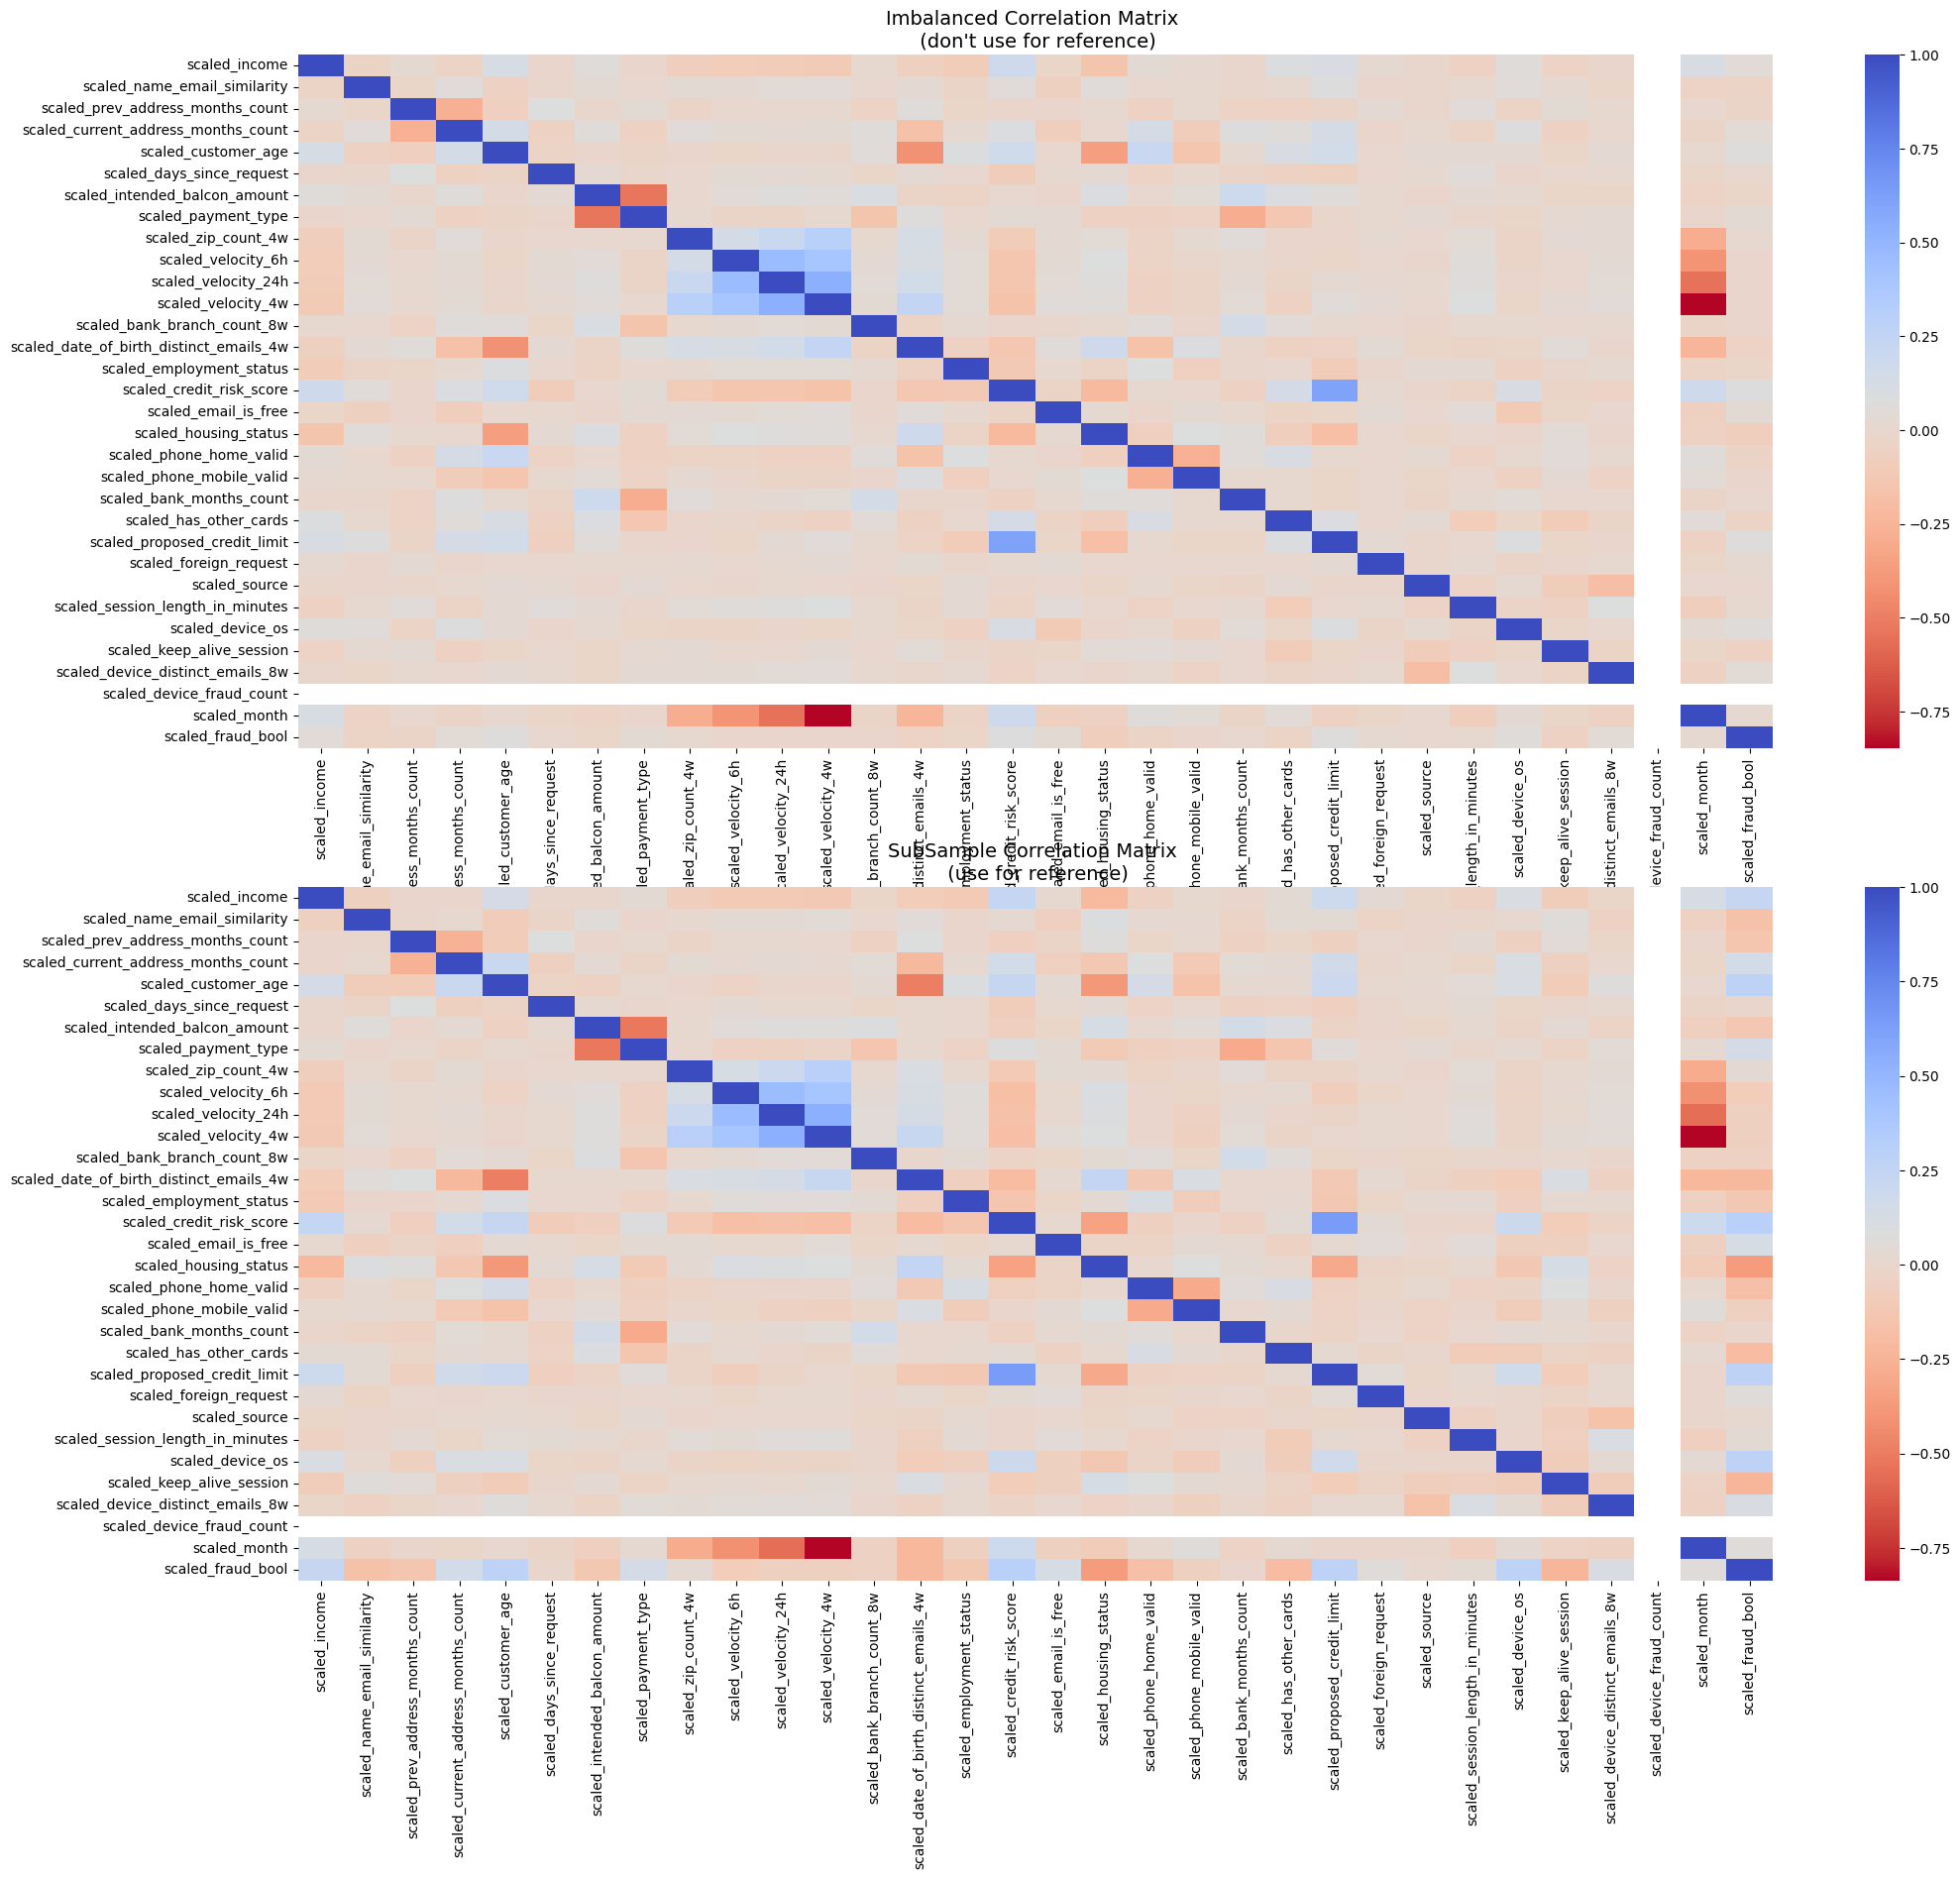

In [25]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = train_data.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

In [27]:
#choose those variable with strong relationship with fraud_bool variable

strong_corr_vars = sub_sample_corr['scaled_fraud_bool'][
    (sub_sample_corr['scaled_fraud_bool'] > 0.3) | (sub_sample_corr['scaled_fraud_bool'] < -0.3)
]

print("Variables with strong positive or negative correlation with scaled_fraud_bool:")
print(strong_corr_vars)


Variables with strong positive or negative correlation with scaled_fraud_bool:
scaled_credit_risk_score    0.3059
scaled_housing_status      -0.3684
scaled_fraud_bool           1.0000
Name: scaled_fraud_bool, dtype: float64


In [29]:
from sklearn.manifold import TSNE
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('scaled_fraud_bool', axis=1)
y = new_df['scaled_fraud_bool']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 2e+02 s
PCA took 0.28 s
Truncated SVD took 5.0 s


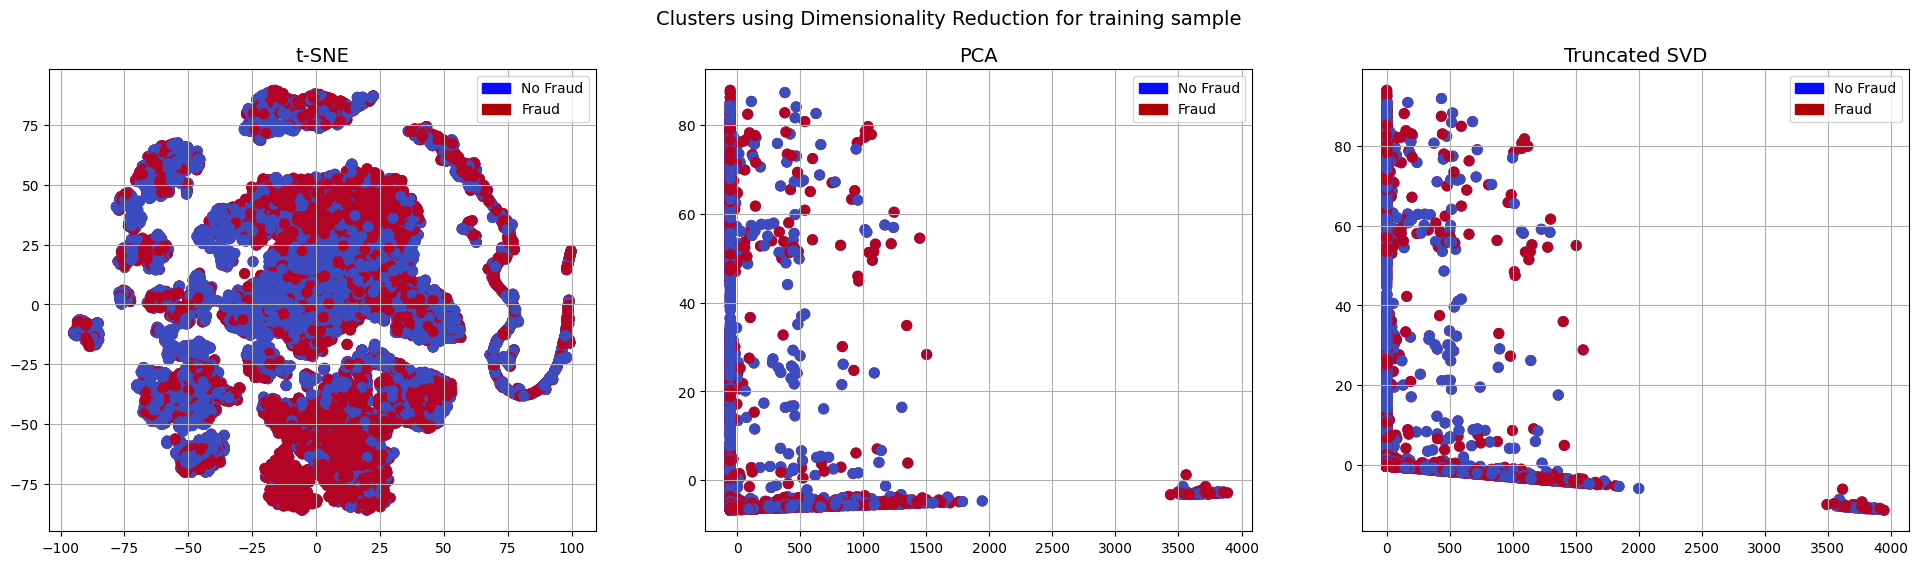

In [30]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction for training sample', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

In [32]:
# Turn the values into an array for feeding the classification algorithms.
X_train = new_df.drop('scaled_fraud_bool', axis=1).values

y_train = new_df['scaled_fraud_bool'].values


In [34]:
# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 78.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 72.0 % accuracy score
Classifiers:  SVC Has a training score of 70.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 71.0 % accuracy score


In [83]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': np.logspace(0, 4, 10, 100, 1000),'max_iter': [10000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_



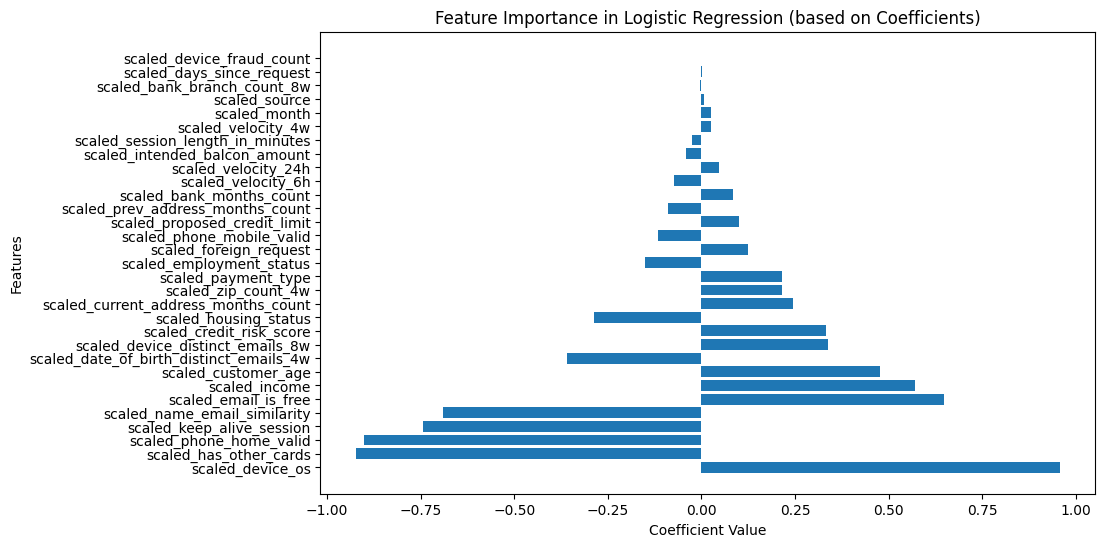

In [38]:
if hasattr(log_reg, 'coef_'):
    coefficients = log_reg.coef_[0]  
    features = np.array(list(new_df.drop('scaled_fraud_bool', axis=1).columns))  

    sorted_idx = np.argsort(np.abs(coefficients))[::-1]  
    sorted_features = features[sorted_idx]
    sorted_coefficients = coefficients[sorted_idx]

    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_coefficients)
    plt.xlabel("Coefficient Value")
    plt.ylabel("Features")
    plt.title("Feature Importance in Logistic Regression (based on Coefficients)")
    plt.show()



In [78]:
knears_params = {"n_neighbors": list(range(2,12,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

#considering the svc perfermance is not good, we applied the randomforest



In [43]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'max_depth': [5, 10, 15],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [5, 10, 20, 50],
    'min_samples_split': [10, 20, 50],
    'n_estimators': [100, 300, 500]
}



rf = RandomForestClassifier(class_weight='balanced')
rf_grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Support Vector Classifier
# svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
# grid_svc = GridSearchCV(SVC(), svc_params)
# grid_svc.fit(X_train, y_train)

# SVC best estimator
# svc = grid_svc.best_estimator_



Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV 4/5; 1/324] START max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100
[CV 5/5; 1/324] START max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100
[CV 1/5; 1/324] START max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100
[CV 2/5; 1/324] START max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100
[CV 2/5; 2/324] START max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=300
[CV 1/5; 2/324] START max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=300
[CV 3/5; 2/324] START max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=300
[CV 3/5; 1/324] START max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100
[CV 4/5; 1/324] END max_depth=5,

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [5, 10, 20, 50],
                         'min_samples_split': [10, 20, 50],
                         'n_estimators': [100, 300, 500]},
             scoring='roc_auc', verbose=10)

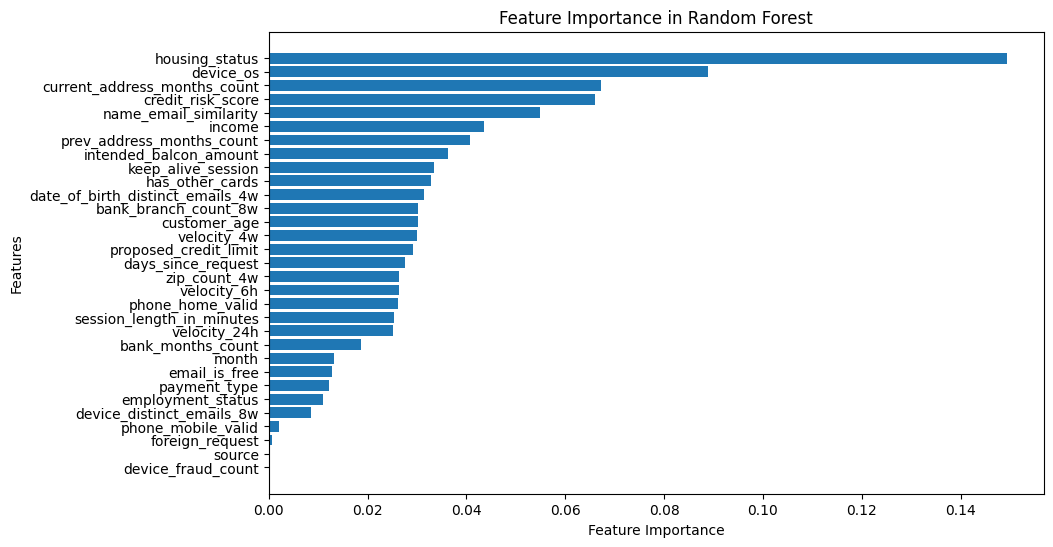

In [46]:
best_model = rf_grid.best_estimator_
feature_importances = best_model.feature_importances_
features = np.array(list(df.drop('fraud_bool', axis=1).columns)) 

sorted_idx = np.argsort(feature_importances)[::-1]  
sorted_features = features[sorted_idx][::-1]
sorted_importances = feature_importances[sorted_idx][::-1]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest")
plt.show()

In [50]:
# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(5,20,1)), 
              "min_samples_leaf": list(range(4,10,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [84]:
#Navie_bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb_best = gnb.fit(X_train, y_train)


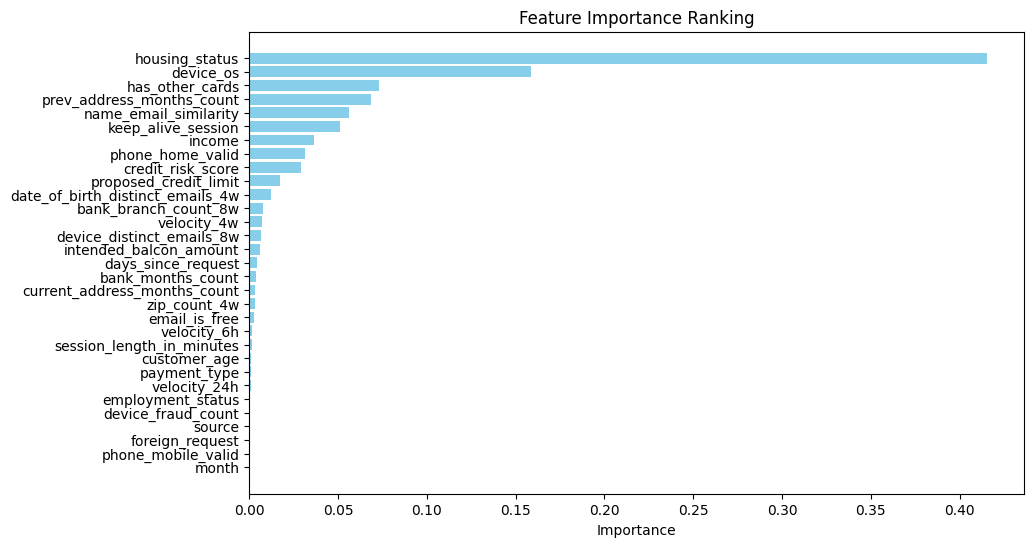

In [51]:

sorted_idx = np.argsort(tree_clf.feature_importances_)[::-1]
sorted_importances = tree_clf.feature_importances_[sorted_idx]
sorted_features = np.array(list(df.drop('fraud_bool', axis=1).columns))[sorted_idx]


plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance Ranking')
plt.gca().invert_yaxis()  
plt.show()


In [85]:
#cross-validation 
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

randomforest_score = cross_val_score(rf_grid.best_estimator_, X_train, y_train, cv=5)
print('Random Forest Classifier Cross Validation Score', round(randomforest_score.mean() * 100, 2).astype(str) + '%')

gnb_score = cross_val_score(gnb_best, X_train, y_train, cv=5)
print('Naive Bayes Classifier Cross Validation Score', round(randomforest_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  78.37%
Knears Neighbors Cross Validation Score 73.72%
Random Forest Classifier Cross Validation Score 80.57%
Naive Bayes Classifier Cross Validation Score 80.57%
DecisionTree Classifier Cross Validation Score 76.27%


In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curves(estimators, estimator_names, X, y, ylim=None, cv=None,
                         n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    n_estimators = len(estimators)
    
    # Calculate the number of rows and columns for subplots based on the number of estimators
    cols = 2  
    rows = (n_estimators + 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 7), sharey=True)
    axes = axes.ravel()  # Flatten the axes array for easy iteration
    
    for idx, (estimator, name) in enumerate(zip(estimators, estimator_names)):
        if ylim is not None:
            plt.ylim(*ylim)
        
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        
        axes[idx].fill_between(train_sizes, train_scores_mean - train_scores_std,
                               train_scores_mean + train_scores_std, alpha=0.1,
                               color="#ff9124")
        axes[idx].fill_between(train_sizes, test_scores_mean - test_scores_std,
                               test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
        axes[idx].plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
                       label="Training score")
        axes[idx].plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
                       label="Cross-validation score")
        axes[idx].set_title(f"{name} Learning Curve", fontsize=14)
        axes[idx].set_xlabel('Training size (m)')
        axes[idx].set_ylabel('Score')
        axes[idx].grid(True)
        axes[idx].legend(loc="best")
    
    # Hide any unused subplots
    if len(axes) > n_estimators:
        for i in range(n_estimators, len(axes)):
            fig.delaxes(axes[i])
    
    plt.tight_layout()
    return plt




<module 'matplotlib.pyplot' from '/Users/zheguan/.pyenv/versions/3.10.13/lib/python3.10/site-packages/matplotlib/pyplot.py'>

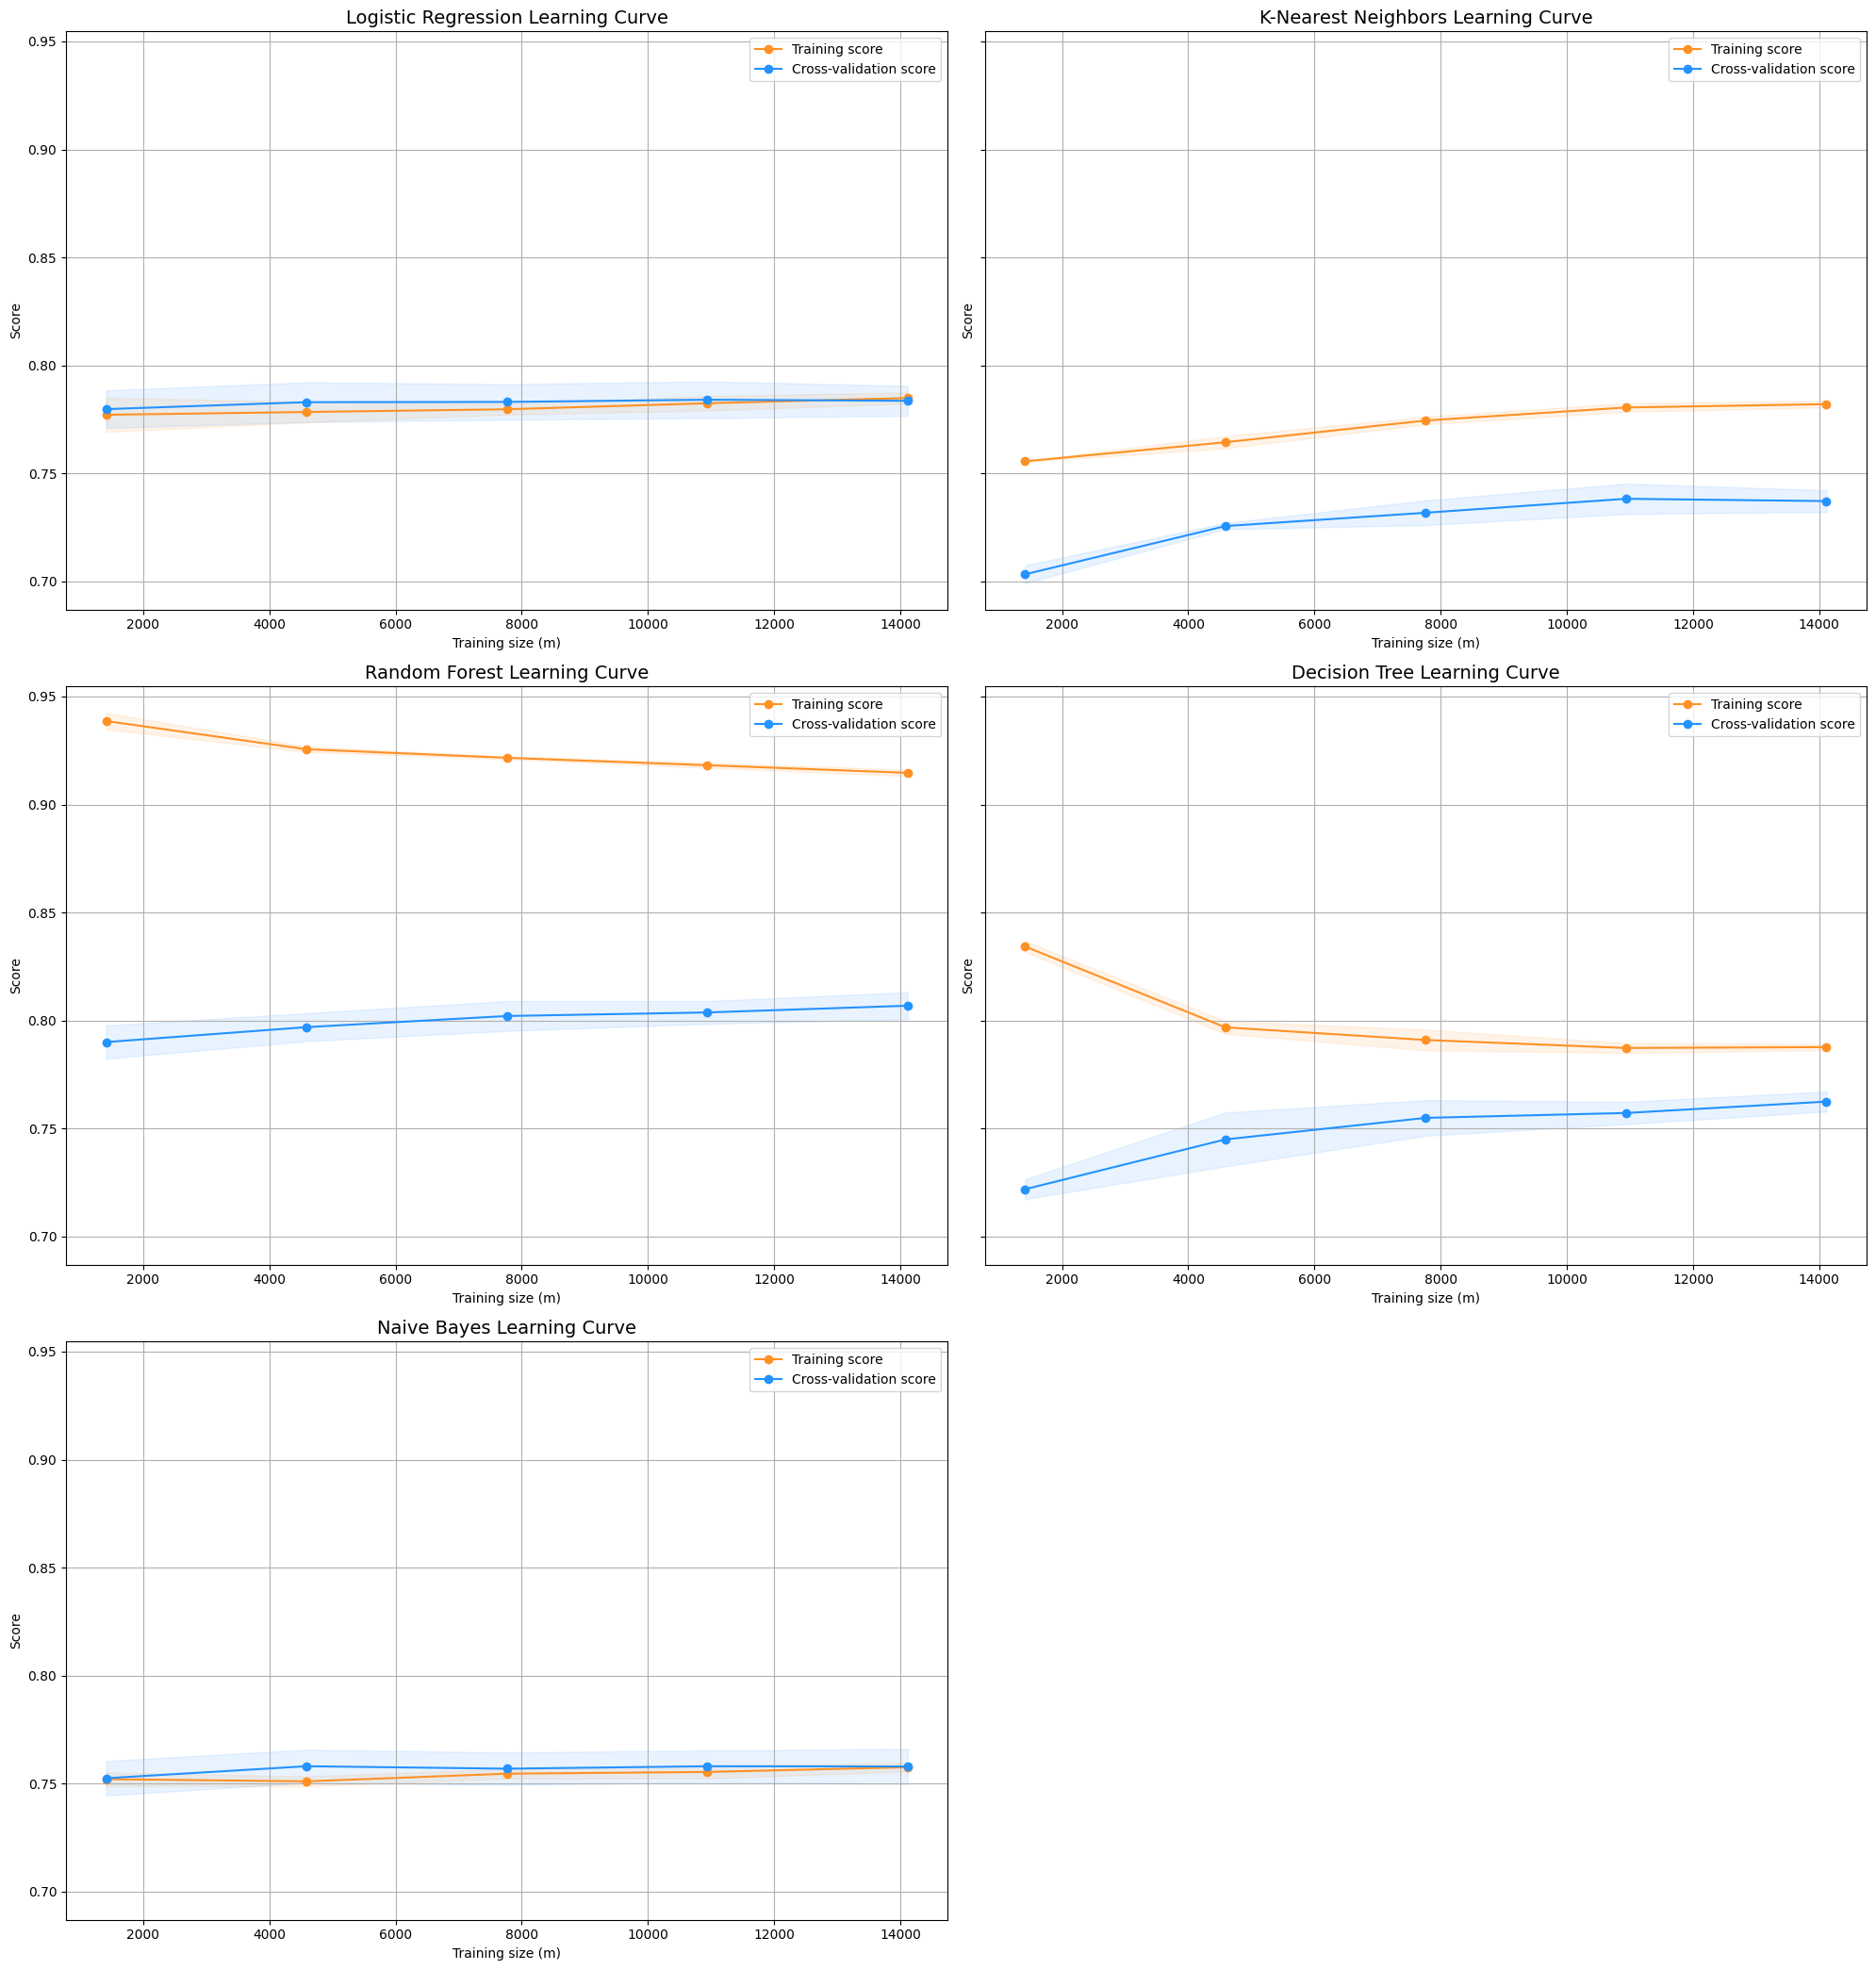

In [87]:
estimators = [log_reg, knears_neighbors, best_model, tree_clf,gnb]
estimator_names = ["Logistic Regression", "K-Nearest Neighbors", "Random Forest", "Decision Tree","Naive Bayes"]
plot_learning_curves(estimators, estimator_names, X_train, y_train)

In [88]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

randomforest_pred = cross_val_predict(best_model, X_train, y_train, cv=5)

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

gnb_pred = cross_val_predict(gnb_best, X_train, y_train, cv=5)



In [89]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Random Forest Classifier: ', roc_auc_score(y_train, randomforest_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))
print('Naive Bayes Classifier: ', roc_auc_score(y_train, gnb_pred))

Logistic Regression:  0.8646006493209119
KNears Neighbors:  0.7372208999206619
Random Forest Classifier:  0.8050549699648646
Decision Tree Classifier:  0.7626657599455967
Naive Bayes Classifier:  0.7579054743284597


In [ ]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Random Forest Classifier: ', roc_auc_score(y_train, randomforest_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))
print('Naive Bayes Classifier: ', roc_auc_score(y_train, gnb_pred))

In [71]:
from sklearn.dummy import DummyClassifier
# Dummy Classifier
dummy = DummyClassifier()
dummy.fit(X_train, y_train)

DummyClassifier()

In [72]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score, accuracy_score

def plot_roc_curves(X, y, models, model_names, figsize=(20,18)):
    """
    Plots ROC curves for a list of models.

    Parameters:
    X (numpy.ndarray or pandas.DataFrame): input features for the models
    y (numpy.ndarray or pandas.DataFrame): target variable
    models (list): list of models to compare
    model_names (list): list of model names to display on the plot
    figsize (tuple): size of the figure to display the plot

    Returns:
    None
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Loop over models and plot ROC curve
    for i, model in enumerate(models):
        y_pred = list(model.predict_proba(X)[:, 1])
        fpr, tpr, threshold = metrics.roc_curve(y, y_pred)
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label=(model_names[i] + ' AUC = %0.4f' % roc_auc), linewidth=2.0)

    ax.grid(False)
    ax.tick_params(length=6, width=2, labelsize=30, grid_color='r', grid_alpha=0.5)
    leg = plt.legend(loc='lower right', prop={'size': 25})
    leg.get_frame().set_edgecolor('b')
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=40)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-.02, 1.02])
    plt.ylim([-.02, 1.02])
    plt.ylabel('True Positive Rate', fontsize=30)
    plt.xlabel('False Positive Rate', fontsize=30)
#     plt.show()

In [90]:
# Define the list of models to compare
models = [log_reg, knears_neighbors, best_model, tree_clf, gnb_best ,dummy]
model_names = ['Logit', 'Knears_neighbors', 'Random Forest','Decision Tree', 'Naive Bayes','Dummy']

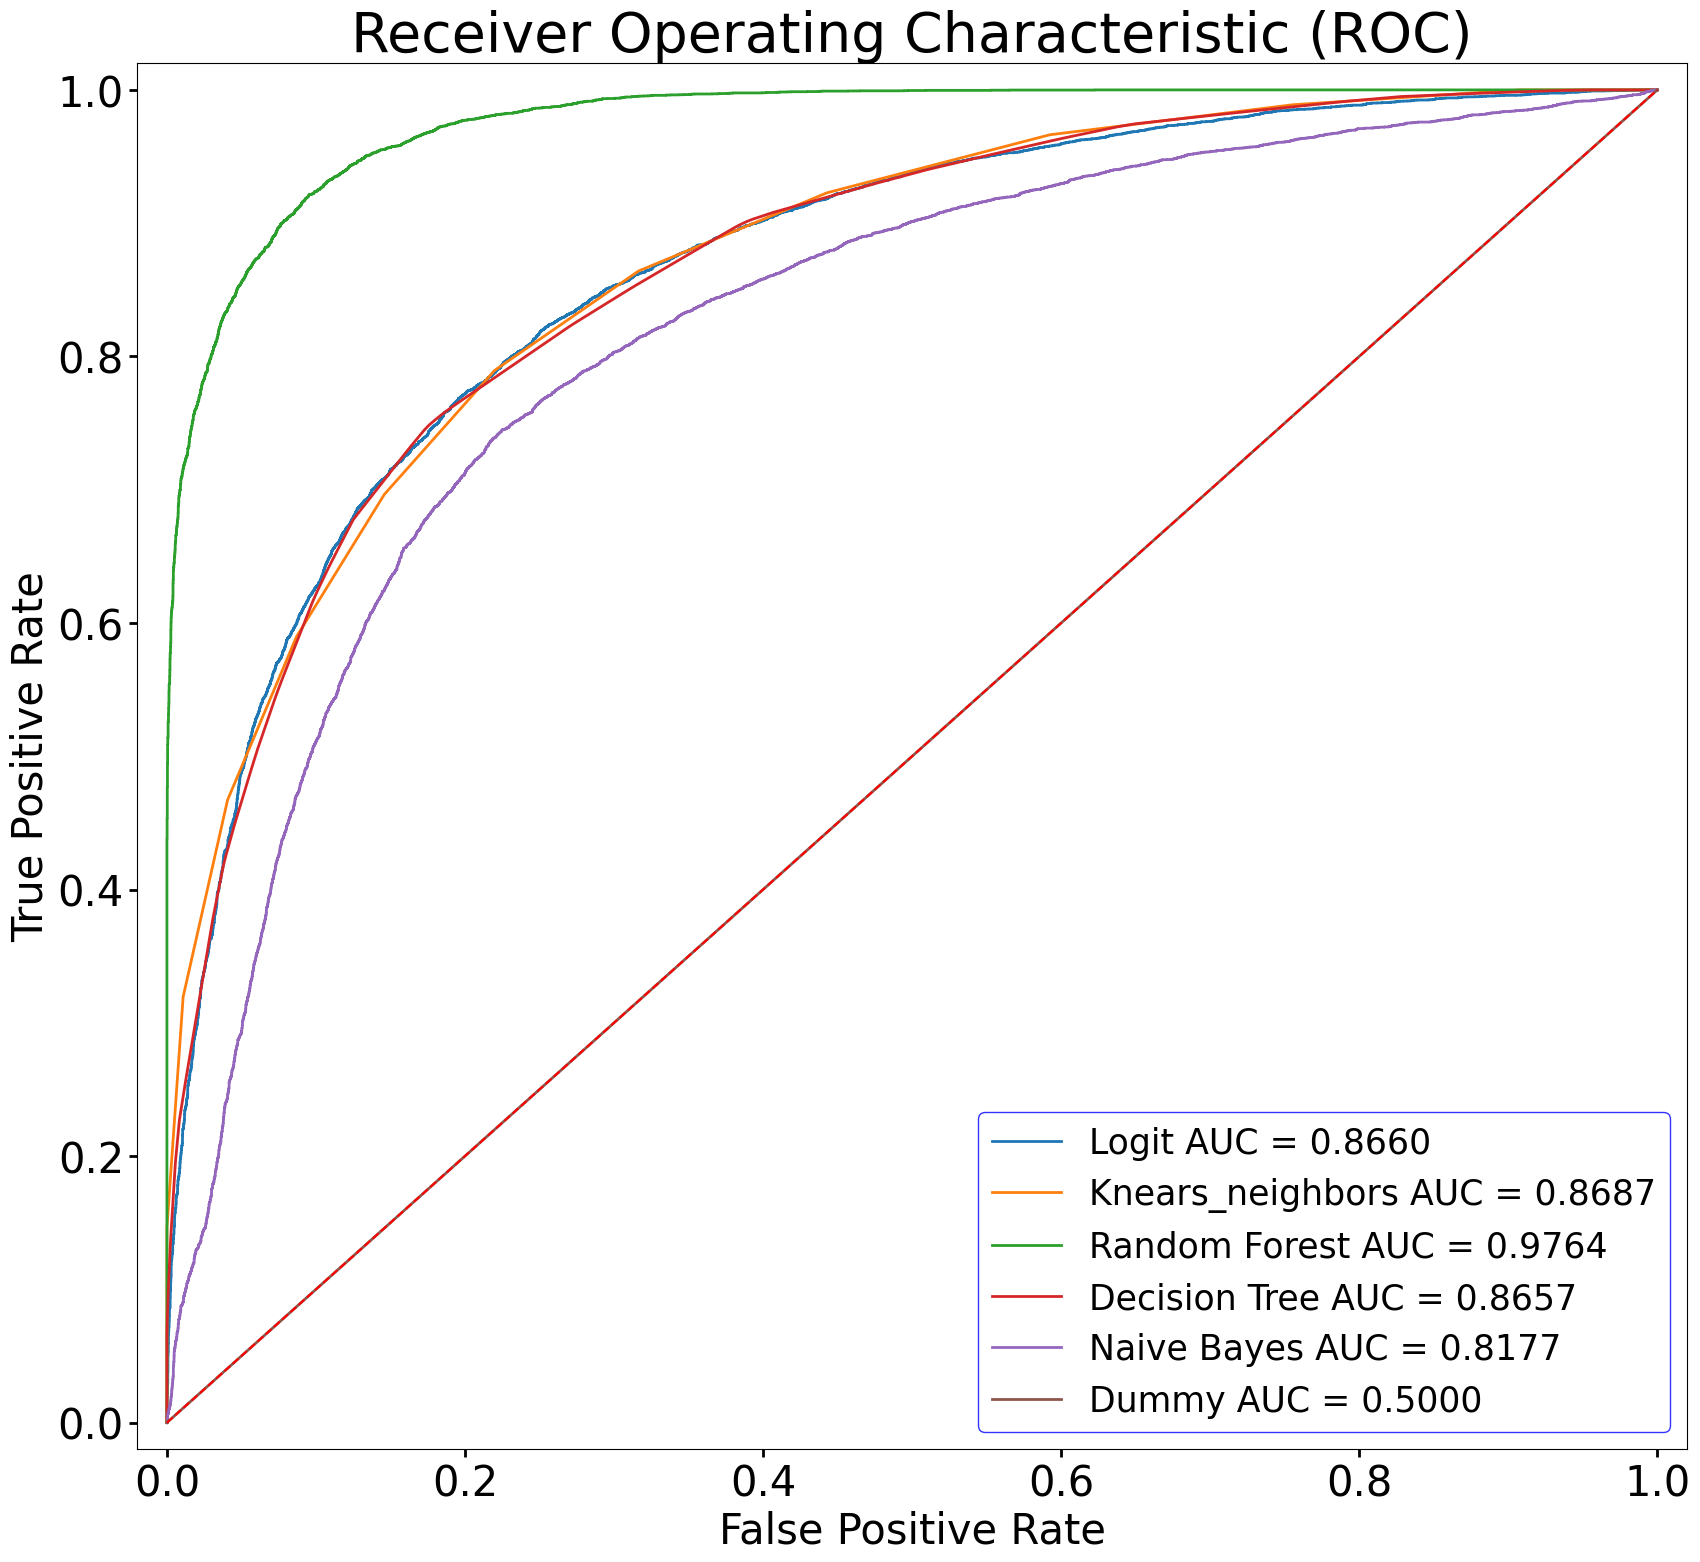

In [91]:
# Plot ROC curves for in-sample data
plot_roc_curves(X_train, y_train, models, model_names)


In [ ]:
#test data should be blinded before all tests

